In [1]:
%load_ext autoreload
%autoreload 2
from FIFOv2 import FIFO 
from multi_latest import Multi
import matplotlib.pyplot as plt
import numpy as np
import math
from spcm import units
import spcm as spcm
import time as time
from time import sleep 
# import API classes into the current namespace
from pulsestreamer import PulseStreamer, Sequence 
import matplotlib.pyplot as plt
import numpy as np 
import hdawg_driver_latest_v2 as awg
from sg396_driver_v1 import SG396


In [2]:
# Coself.samplesself.samplesect to Pulse Streamer
ip = '10.135.70.193' 
ps = PulseStreamer(ip)
Multi = Multi('dev/spcm0')

Connect to Pulse Streamer via JSON-RPC.
IP / Hostname: 10.135.70.193
Pulse Streamer 8/2 firmware: v1.5.2
Client software: v1.7.0
Your client software is more up to date than the Pulse Streamer 8/2 firmware. We recommend updating the firmware of your Pulse Streamer 8/2.
For detailed information visit https://www.swabianinstruments.com/pulse-streamer-8-2/downloads/ or contact support@swabianinstruments.com
Successfully connected to the digitizer


In [3]:
awg = awg.HDAWG('dev8181', '127.0.0.1', 8004)

Trying to connect to dev8181 on interface USB
Connected to dev8181 via data server 127.0.0.1:8004 and interface USB


In [4]:
sg = SG396('TCPIP::10.135.70.65::inst0::INSTR')


connected to SG396 [TCPIP::10.135.70.65::inst0::INSTR]


In [5]:
experiment_settings = {
    "Laser Power": 30,
    "ODMR MW Probe Time": 50,
    "Sideband Mod. Frequency (MHz)": 30,
    "Sideband Power (mV)": 150,
    "Sideband Choice": "Lower",
    "I Offset (mV)": -2,
    "Q Offset (mV)": -4,
    "Detector": "APD",
    "num_pts": 20
}


In [6]:
num_pts=10

In [7]:
max_sideband=20*1e6
mod_frequencies=np.linspace(0,max_sideband,num_pts)

In [8]:
awg_parameters = {
    "seq": "CW ODMR",
    "i_offset": -2*1e-3, #mV
    "q_offset": -4*1e-3, #mV
    "probe_length": 50*1e-6, #us
    "sideband_power": 150 * 1e-3, #mV
    "sideband_freqs": mod_frequencies, #MHz
    "iq_phases": [0,90],
    "num_pts": num_pts
}



In [9]:
awg.set_sequence(**{'seq': 'CW ODMR',
                    'i_offset': awg_parameters['i_offset'],
                    'q_offset': awg_parameters['q_offset'],
                    'probe_length': awg_parameters['probe_length'], 
                    'sideband_power': awg_parameters['sideband_power'],
                    'sideband_freqs': awg_parameters['sideband_freqs'], 
                    'iq_phases': awg_parameters['iq_phases'],
                    'num_pts': awg_parameters['num_pts']})
    

AWG COMPILE STATUS:  -1
AWG COMPILE STATUS again:  2
Warning during sequencer compilation:  Compilation started
Detected 1 devices with a total of 1 AWG cores.
Compiling source string
Warning (line: 7): waveform '__playWave_7_3' size 119999 is not aligned to 16 samples and will be zero-extended to 120000 samples
Warning (line: 11): waveform '__playWave_7_3' size 119999 is not aligned to 16 samples and will be zero-extended to 120000 samples
Warning (line: 15): waveform '__playWave_7_3' size 119999 is not aligned to 16 samples and will be zero-extended to 120000 samples
Warning (line: 19): waveform '__playWave_7_3' size 119999 is not aligned to 16 samples and will be zero-extended to 120000 samples
Warning (line: 23): waveform '__playWave_7_3' size 119999 is not aligned to 16 samples and will be zero-extended to 120000 samples
Warning (line: 27): waveform '__playWave_7_3' size 119999 is not aligned to 16 samples and will be zero-extended to 120000 samples
Warning (line: 31): waveform '_

In [46]:
# To set the configuration, make a dictionary with the key and value
num_iters=1
config1={'num_samples' :None,
         'runs': num_pts*4000,
         'readout_ch' :0,
         'num_pts_in_exp':2,
         'num_iters':num_iters}

In [47]:
# configure signal generator for NV drive
sg.set_frequency(2.3e9) # set carrier frequency
sg.set_rf_amplitude(100e-6) # set MW power
sg.set_mod_type(7) # quadrature amplitude modulation
sg.set_mod_subtype(1) # no constellation mapping
sg.set_mod_function('IQ', 5) # external modulation
sg.set_mod_toggle(1) # turn on modulation mode

In [48]:
# Assign_param takes the configuration and gives it to the class dictionary 

Multi.assign_param(settings_dict=config1)
Multi.config()

SETTINGS: card timeout =  20 s
SETTINGS: # segments =  512 Sa
SETTINGS: sampling freq =  0.5 GHz


In [84]:
probe_time = 50e3
readout_time = 1000
trig_time = 10


def CW_ODMR(num_freqs):
        
        '''
        CW ODMR Sequence
        Laser on for entire sequence. 
        MW on for probe_time.
        MW off for probe_time.
        User sets how many voltage samples (num_clocks) to take during each MW on/off window.
        '''
    
        def SingleCW_ODMR():
            
            # create sequence object
            seq_on = ps.createSequence()
            seq_off = ps.createSequence()

            # digitizer trigger timing
            clock_off1 = probe_time - 30*readout_time - trig_time
            clock_off2 = 30*readout_time

            iq_off = probe_time - trig_time

            # define sequence structure for clock and MW I/Q channels
            dig_clock_seq = [(clock_off1, 0), (trig_time, 1), (clock_off2, 0)]
            
            mw_iq_seq_on = [(trig_time, 1), (iq_off, 0)]
            mw_iq_seq_off = [(probe_time, 0)]

            # assign sequences to respective channels
            seq_on.setDigital(1, dig_clock_seq) # digitizer trigger
            seq_on.setDigital(2, mw_iq_seq_on) # MW IQ

            seq_off.setDigital(1, dig_clock_seq) # digitizer trigger
            seq_off.setDigital(2, mw_iq_seq_off) # MW IQ

            return seq_on + seq_off

        seqs = ps.createSequence()

        for i in range(num_freqs):
            seqs += SingleCW_ODMR()

        return seqs

In [81]:
ps_seq = CW_ODMR(1)

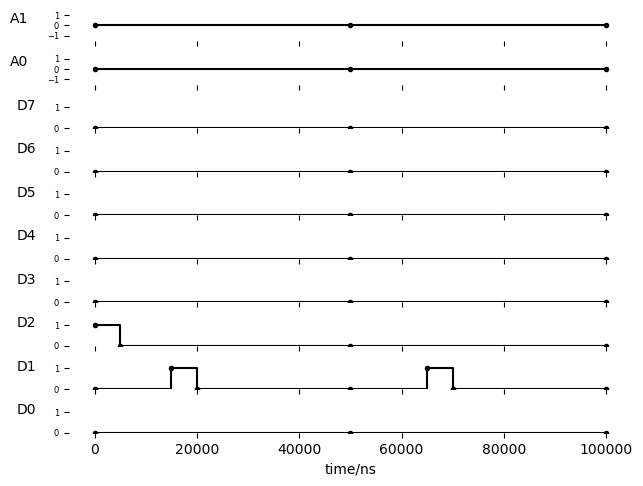

In [82]:
ps_seq.plot()

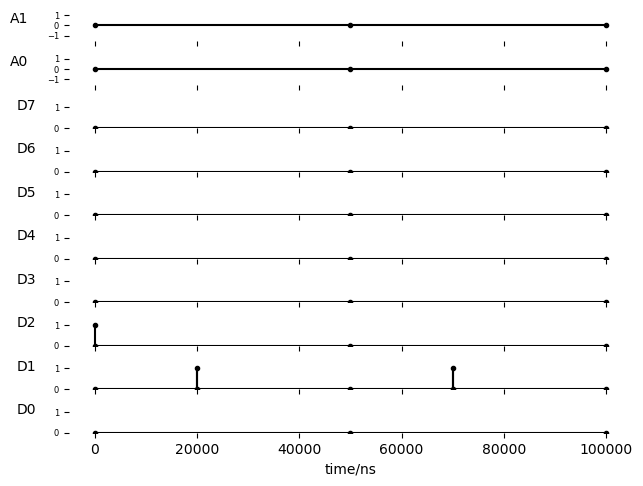

In [76]:
ps_seq.plot()

In [52]:
n_runs = ps.REPEAT_INFINITELY
ps.stream(ps_seq, n_runs)


In [53]:
Multi.config()
sg.set_rf_toggle(1)
Multi.start_buffer()

DATA=Multi.acquire()

Multi.stop_card()
Multi.restart()

SETTINGS: card timeout =  20 s
SETTINGS: # segments =  512 Sa
SETTINGS: sampling freq =  0.5 GHz
Card stopped


In [54]:
#STOP 
ps.forceFinal()
sg.set_rf_toggle(0)
awg.set_disabled()


In [55]:
mw_on=np.mean(DATA[0::2],axis=0)
mw_off=np.mean(DATA[1::2],axis=0)

In [57]:
mw_on_raw=DATA[0::2]
mw_off_raw=DATA[1::2]

In [58]:
iters_on1=mw_on[0::10]
iters_on2=mw_on[1::10]
iters_on3=mw_on[2::10]
iters_on4=mw_on[3::10]
iters_on5=mw_on[4::10]
iters_on6=mw_on[5::10]
iters_on7=mw_on[6::10]
iters_on8=mw_on[7::10]
iters_on9=mw_on[8::10]
iters_on10=mw_on[9::10]


In [59]:
iters_off1=mw_off[0::10]
iters_off2=mw_off[1::10]
iters_off3=mw_off[2::10]
iters_off4=mw_off[3::10]
iters_off5=mw_off[4::10]
iters_off6=mw_off[5::10]
iters_off7=mw_off[6::10]
iters_off8=mw_off[7::10]
iters_off9=mw_off[8::10]
iters_off10=mw_off[9::10]


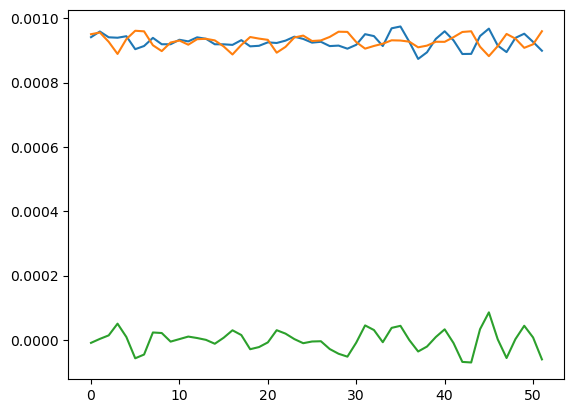

In [60]:
A=np.mean(iters_on1,axis=1)
B=np.mean(iters_off1,axis=1)
plt.plot(A)
plt.plot(B)
diff1=A-B
plt.plot(A-B)

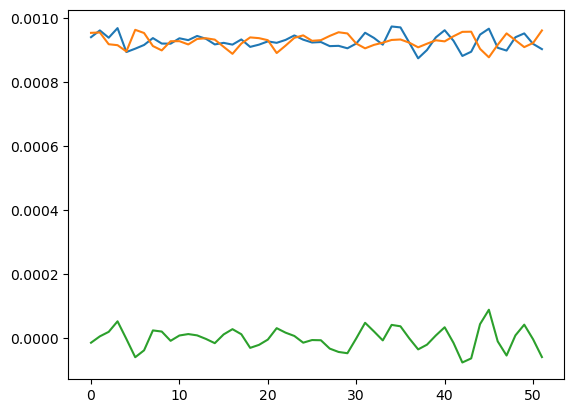

In [61]:
A=np.mean(iters_on2,axis=1)
B=np.mean(iters_off2,axis=1)
plt.plot(A)
plt.plot(B)
diff2=A-B
plt.plot(A-B)

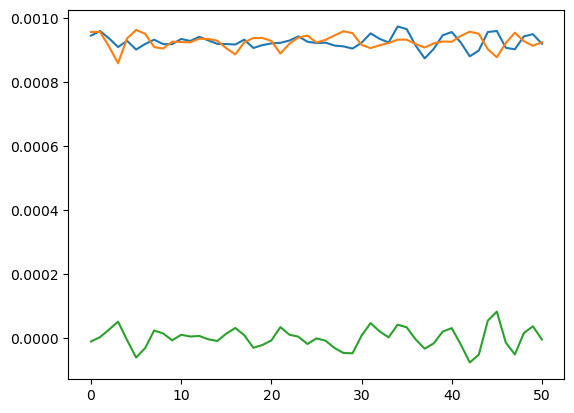

In [62]:
A=np.mean(iters_on3,axis=1)
B=np.mean(iters_off3,axis=1)
plt.plot(A)
plt.plot(B)
diff3=A-B
plt.plot(A-B)

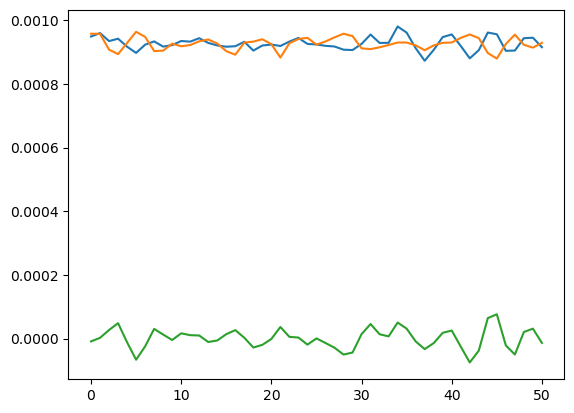

In [63]:
A=np.mean(iters_on4,axis=1)
B=np.mean(iters_off4,axis=1)
plt.plot(A)
plt.plot(B)
diff4=A-B
plt.plot(A-B)

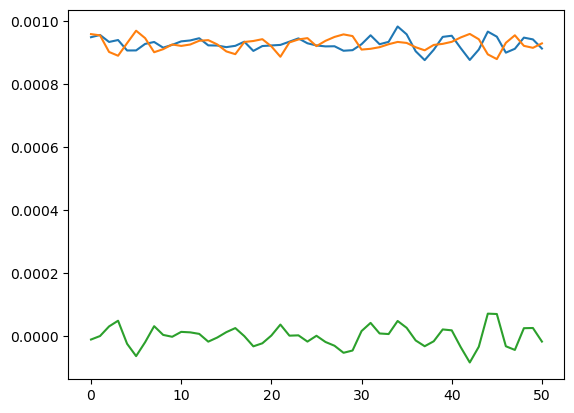

In [64]:
A=np.mean(iters_on5,axis=1)
B=np.mean(iters_off5,axis=1)
plt.plot(A)
plt.plot(B)
diff5=A-B
plt.plot(A-B)

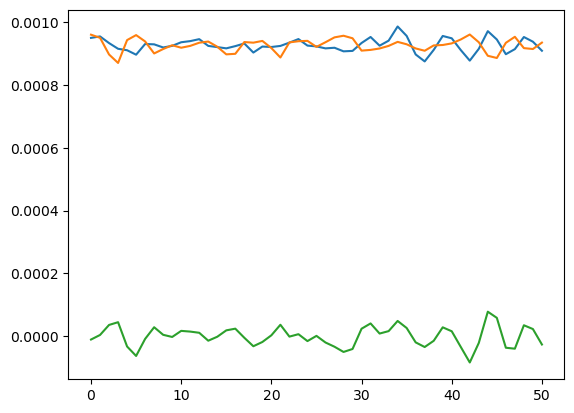

In [65]:
A=np.mean(iters_on6,axis=1)
B=np.mean(iters_off6,axis=1)
plt.plot(A)
plt.plot(B)
diff6=A-B
plt.plot(A-B)

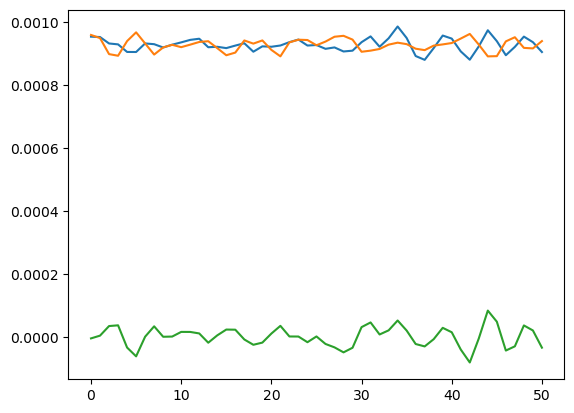

In [66]:
A=np.mean(iters_on7,axis=1)
B=np.mean(iters_off7,axis=1)
plt.plot(A)
plt.plot(B)
diff7=A-B
plt.plot(A-B)

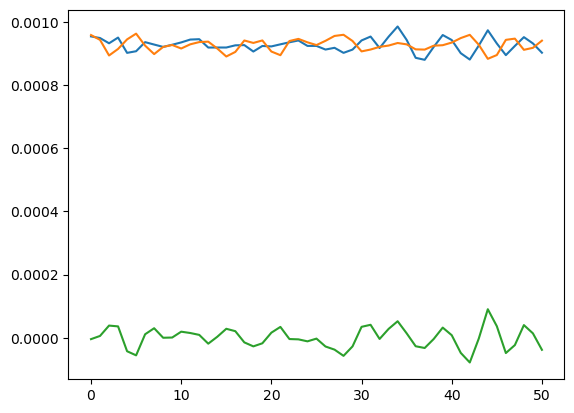

In [67]:
A=np.mean(iters_on8,axis=1)
B=np.mean(iters_off8,axis=1)
plt.plot(A)
plt.plot(B)
diff8=A-B
plt.plot(A-B)

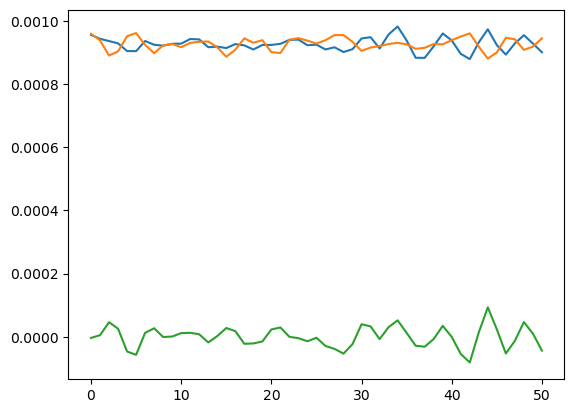

In [68]:
A=np.mean(iters_on9,axis=1)
B=np.mean(iters_off9,axis=1)
plt.plot(A)
plt.plot(B)
diff9=A-B
plt.plot(A-B)

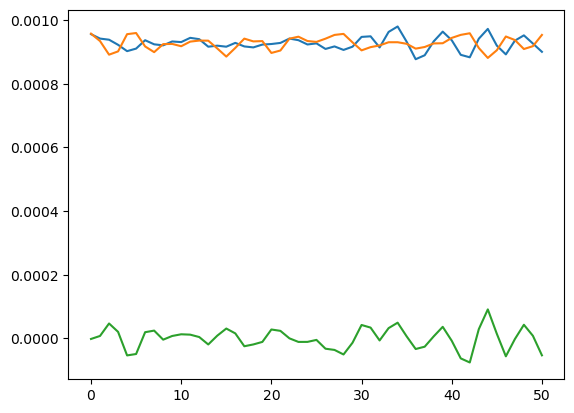

In [69]:
A=np.mean(iters_on10,axis=1)
B=np.mean(iters_off10,axis=1)
plt.plot(A)
plt.plot(B)
diff10=A-B
plt.plot(A-B)

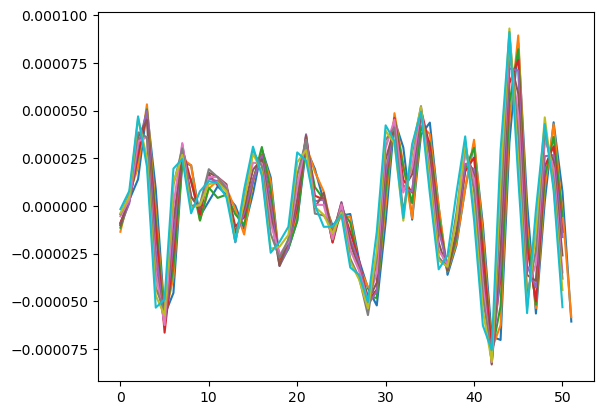

In [70]:
plt.plot(diff1)
plt.plot(diff2)
plt.plot(diff3)
plt.plot(diff4)
plt.plot(diff5)
plt.plot(diff6)
plt.plot(diff7)
plt.plot(diff8)
plt.plot(diff9)
plt.plot(diff10)


In [71]:
mw_data=[np.mean(iters_on1),
         np.mean(iters_on2),
         np.mean(iters_on3),
         np.mean(iters_on4),
         np.mean(iters_on5),
         np.mean(iters_on6),
         np.mean(iters_on7),
         np.mean(iters_on8),
         np.mean(iters_on9),
         np.mean(iters_on10)]
mw_data

[0.0009270629295935999,
 0.0009271273686335637,
 0.0009265474207261029,
 0.0009272399303959864,
 0.0009265202540977328,
 0.0009263621610753678,
 0.0009266776888978247,
 0.0009270331887637867,
 0.0009265724331724876,
 0.0009266291599647672]

In [72]:
mwoff_data=[np.mean(iters_off1),
         np.mean(iters_off2),
         np.mean(iters_off3),
         np.mean(iters_off4),
         np.mean(iters_off5),
         np.mean(iters_off6),
         np.mean(iters_off7),
         np.mean(iters_off8),
         np.mean(iters_off9),
         np.mean(iters_off10)]
mwoff_data

[0.0009281311035156251,
 0.0009275519737830528,
 0.0009267344156901042,
 0.0009266736797257965,
 0.0009267629586014094,
 0.0009260724834367342,
 0.0009264619116689644,
 0.0009269841212852328,
 0.0009274230358647364,
 0.000926707608092065]

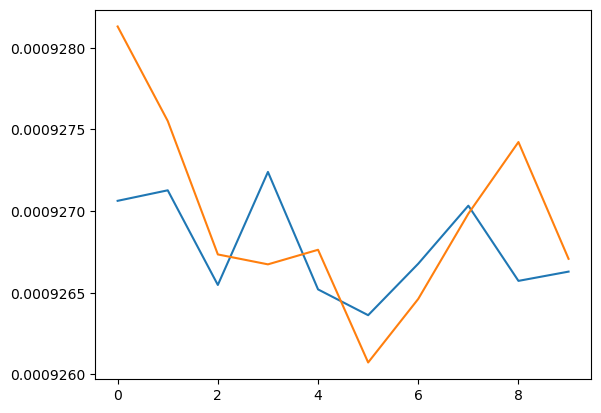

In [73]:
plt.plot(mw_data)
plt.plot(mwoff_data)

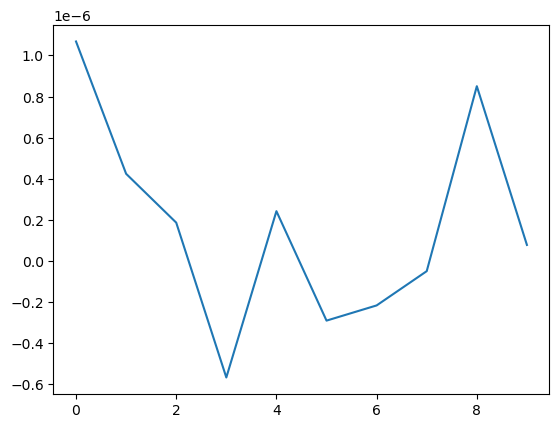

In [74]:
plt.plot(-np.array(mw_data)+np.array(mwoff_data))